# Ex
ocentric CPR Depth Result Calculation

### Unsupervised

In [1]:
import pandas as pd
import re

# Define file paths
# Define file paths
results_log_path = './exocentric_results/july10_final_exocentric_kinect_cpr_depth_window_results.txt'
output_csv_path  = './exocentric_results/july10_final_exocentric_kinect_cpr_depth_subject_summary.csv'



In [3]:
import re
import pandas as pd
import numpy as np

# Regex to capture: subject (prefix before first underscore), predicted depth, GT depth, inference time
pattern = re.compile(
    r"File:([^_]+)_[^,]*,Window:\d+,"
    r"Predicted_CPR_Depth:([\d.]+),"
    r"GT_CPR_Depth:([\d.]+),"
    r"InferenceTimeSeconds:([\d.]+)"
)

records = []
with open(results_log_path, 'r') as f:
    for line in f:
        m = pattern.search(line)
        if not m:
            continue
        subject           = m.group(1)
        predicted_depth   = float(m.group(2))
        gt_depth          = float(m.group(3))
        inference_time    = float(m.group(4))

        # Calculate MAPE term-wise (will aggregate later)
        if gt_depth != 0:
            ape = abs(predicted_depth - gt_depth) / gt_depth * 100
        else:
            ape = np.nan  # avoid division by zero

        records.append({
            'Subject': subject,
            'GT CPR Depth': gt_depth,
            'Predicted CPR Depth': predicted_depth,
            'Inference Time': inference_time,
            'Squared Error': (predicted_depth - gt_depth) ** 2,
            'Absolute Error': abs(predicted_depth - gt_depth),
            'APE': ape
        })

# Build DataFrame
df = pd.DataFrame(records)

# Compute per-subject aggregates
summary = df.groupby('Subject', as_index=False).agg({
    'GT CPR Depth':        'mean',
    'Predicted CPR Depth': 'mean',
    'Inference Time':      'mean',
    'Squared Error':       'mean',
    'Absolute Error':      'mean',
    'APE':                 'mean'
})

# Compute RMSE from mean squared error
summary['RMSE CPR Depth'] = np.sqrt(summary['Squared Error'])

# Drop intermediate column
summary = summary.drop(columns=['Squared Error'])

# Rename columns for clarity
summary = summary.rename(columns={
    'GT CPR Depth':        'Average GT CPR Depth',
    'Predicted CPR Depth': 'Average Predicted CPR Depth',
    'Inference Time':      'Average Inference Time',
    'Absolute Error':      'Average Absolute Error',
    'APE':                 'Average MAPE (%)'
})

# Save to CSV
summary.to_csv(output_csv_path, index=False)
print(f"Subject summary with RMSE and MAPE saved to {output_csv_path}")
print(summary)


Subject summary with RMSE and MAPE saved to ./exocentric_results/july10_final_exocentric_kinect_cpr_depth_subject_summary.csv
   Subject  Average GT CPR Depth  Average Predicted CPR Depth  \
0       P0             23.479024                     7.262927   
1       P1             33.870909                    29.354545   
2      P10             21.123333                    32.746667   
3      P11             37.805806                    23.585806   
4      P12             23.641538                    18.096538   
5      P14             43.461304                    40.731739   
6      P15             19.324000                    19.055500   
7      P16             28.862308                    11.312692   
8       P2             25.429130                    12.288261   
9      P20             21.863810                    13.444286   
10     P21             33.261250                    29.515833   
11     P22             14.287857                     9.937857   
12      P3             43.632

# Feedback evaluation metrics

In [6]:
import pandas as pd
import numpy as np
import re

def compute_metrics(labels):
    tp = labels.count('TP')
    fp = labels.count('FP')
    tn = labels.count('TN')
    fn = labels.count('FN')
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    feedback_acc = (tp + tn) / len(labels) if len(labels) > 0 else 0.0
    return precision, recall, f1, feedback_acc

def single_row_depth_label(gt, pred):
    if 50 <= gt <= 60:
        if 50 <= pred <= 60:
            return 'TN'
        else:
            return 'FP'
    else:
        if gt < 50:
            if pred < 50:
                return 'TP'
            else:
                return 'FN'
        else:  # gt > 60
            if pred > 60:
                return 'TP'
            else:
                return 'FN'

# Your record generation logic
pattern = re.compile(
    r"File:([^_]+)_[^,]*,Window:\d+," +
    r"Predicted_CPR_Depth:([\d.]+)," +
    r"GT_CPR_Depth:([\d.]+)," +
    r"InferenceTimeSeconds:([\d.]+)"
)

records = []
with open(results_log_path, 'r') as f:
    for line in f:
        m = pattern.search(line)
        if not m:
            continue
        subject = m.group(1)
        predicted_depth = float(m.group(2))
        gt_depth = float(m.group(3))
        inference_time = float(m.group(4))
        ape = abs(predicted_depth - gt_depth) / gt_depth * 100 if gt_depth != 0 else np.nan
        records.append({
            'Subject': subject,
            'GT CPR Depth': gt_depth,
            'Predicted CPR Depth': predicted_depth,
            'Inference Time': inference_time,
            'Squared Error': (predicted_depth - gt_depth) ** 2,
            'Absolute Error': abs(predicted_depth - gt_depth),
            'APE': ape
        })

df = pd.DataFrame(records)

# Add feedback label
df['Depth Feedback Label'] = df.apply(
    lambda row: single_row_depth_label(row['GT CPR Depth'], row['Predicted CPR Depth']), axis=1
)

# Compute metrics
labels = df['Depth Feedback Label'].tolist()
precision, recall, f1, feedback_acc = compute_metrics(labels)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Feedback Accuracy:", feedback_acc)

# Per-subject metrics
subject_metrics = []

for subject_id, group in df.groupby("Subject"):
    sub_labels = group['Depth Feedback Label'].tolist()
    sub_prec, sub_rec, sub_f1, sub_acc = compute_metrics(sub_labels)

    subject_metrics.append({
        'subject_id': subject_id,
        'precision': sub_prec,
        'recall': sub_rec,
        'f1_score': sub_f1,
        'feedback_accuracy': sub_acc
    })

metrics_df = pd.DataFrame(subject_metrics)

# Calculate subject-wise averages
average_metrics = {
    'subject_id': 'AVERAGE',
    'precision': metrics_df['precision'].mean(),
    'recall': metrics_df['recall'].mean(),
    'f1_score': metrics_df['f1_score'].mean(),
    'feedback_accuracy': metrics_df['feedback_accuracy'].mean()
}

# Append average row
metrics_df = pd.concat([metrics_df, pd.DataFrame([average_metrics])], ignore_index=True)

# Save
df.to_csv(f"./exocentric_results/july10_exo_video_depth_feedback_with_labels.csv", index=False)
print(f"✅ Saved row-wise CSV with feedback labels: ./exocentric_results/july10_exo_video_depth_feedback_with_labels.csv")

metrics_df.to_csv(f"./exocentric_results/july10_exo_video_depth_feedback_subject_summary_metrics.csv", index=False)
print(f"✅ Saved per-subject summary CSV (with average row): ./exocentric_results/july10_exo_video_depth_feedback_subject_summary_metrics.csv")


Precision: 0.7729636048526863
Recall: 0.8955823293172691
F1 Score: 0.8297674418604651
Feedback Accuracy: 0.7113564668769716
✅ Saved row-wise CSV with feedback labels: ./exocentric_results/july10_exo_video_depth_feedback_with_labels.csv
✅ Saved per-subject summary CSV (with average row): ./exocentric_results/july10_exo_video_depth_feedback_subject_summary_metrics.csv


### Supervised

# Compare smartwatch cpr rate and vision rate

   participant   GT_Depth  Pred_Depth  Depth_error  GT_CPR_rate  \
0           P0  29.537883   29.650041     7.978208    11.589623   
1           P1  41.687441   40.155937     9.633898     8.771186   
2          P10  25.837629   31.008675     5.826111    10.500000   
3          P11  29.511459   30.055126    11.039886    11.409091   
4          P12  19.084786   30.689360    11.838481    10.518987   
5          P14  41.351939   35.556689    14.586923     8.942308   
6          P15  24.935938   29.564955     7.526154    10.551282   
7          P16  27.369919   30.898963     9.864500    12.687500   
8           P2  24.147902   40.638144    16.490755    14.254717   
9          P20  27.027362   29.298826     7.573444     9.977778   
10         P21  28.621427   30.661842    13.206700    10.640000   
11         P22  12.798503   29.439477    16.640400    13.440000   
12          P3  41.970961   34.083512    13.475342    10.904110   
13          P4  34.745326   42.135338    13.461286    14.14285

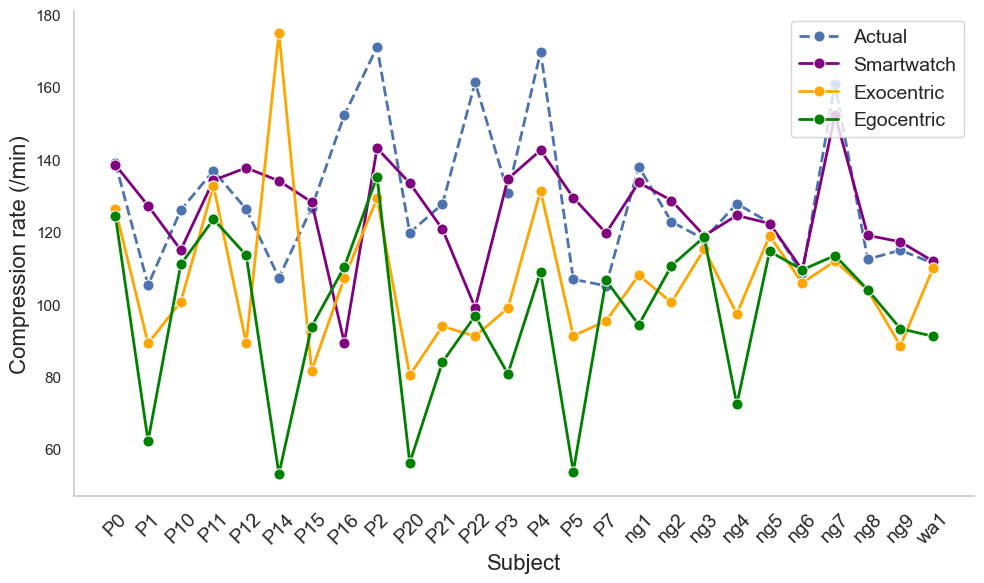

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

egocentric_data = summary_df

# Load the smartwatch CSV data into a DataFrame
smartwatch_data = pd.read_csv("../smartwatch/averages_output.csv")
# Load the exocentric vision summary data
vision_data = pd.read_csv('./outlier_depth_window_subject_summary.csv')
# Load the egocentric vision summary data
egocentric_vision_data = pd.read_csv(output_csv_path)

# Merge the data on the participant/subject column
merged_data = pd.merge(
    smartwatch_data,
    vision_data.rename(columns={'Subject': 'participant'}), 
    on='participant', 
    how='inner'
)

merged_data = pd.merge(
    merged_data,
    egocentric_data.rename(columns={'Subject': 'participant'}), 
    on='participant', 
    how='inner'
)

print(merged_data)

# Create directory for saving plots
results_plots = './result_plots'
os.makedirs(results_plots, exist_ok=True)

# Set plot style
sns.set(style="whitegrid")

# Initialize the matplotlib figure
plt.figure(figsize=(10, 6))

# Plot GT CPR Rate, Smartwatch Predicted CPR Rate, and Vision Predicted CPR Rate
sns.lineplot(x='participant', y='GT_CPR_rate_per_min', data=merged_data, marker='o', label='Actual', color='b', linestyle='--', linewidth=2, markersize=8)
sns.lineplot(x='participant', y='Keshara_Low_Pass_Pred_CPR_rate_per_min', data=merged_data, marker='o', label='Smartwatch', color='purple', linewidth=2, markersize=8)
sns.lineplot(x='participant', y='Average Predicted CPR cycles per min', data=merged_data, marker='o', label='Exocentric', color='orange', linewidth=2, markersize=8)
sns.lineplot(x='participant', y='Average Predicted CPR Rate', data=merged_data, marker='o', label='Egocentric', color='green', linewidth=2, markersize=8)

# Customize plot
plt.xlabel("Subject", fontsize=16)
plt.ylabel("Compression rate (/min)", fontsize=16)
plt.xticks(rotation=45, fontsize=14)
plt.legend(loc='upper right', fontsize=14)
plt.grid(False)
sns.despine()
plt.tight_layout()

# Save and show plot
plt.savefig(f'{results_plots}/CPR_Rate_Comparison_with_Vision.png')
plt.show()


